### Описание задачи

Мы имеем данные виноградных  клеток c номерами 1 -10


Площадь 1 клетки = 4 Га


!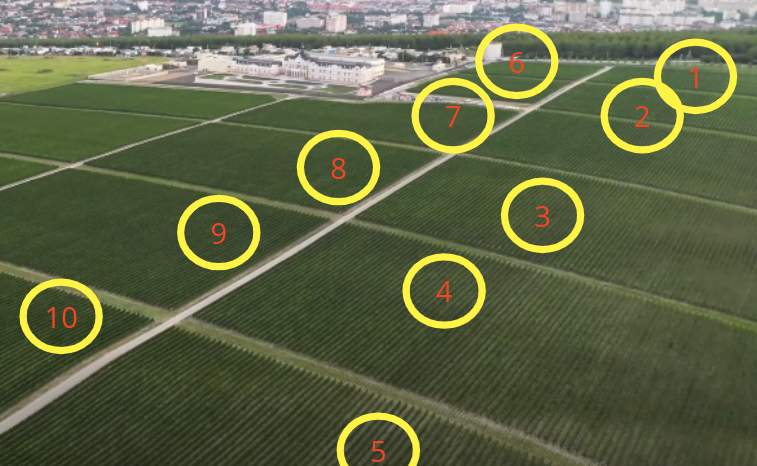

### Импорты

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
import pandas as pd
import numpy as np
import pickle
import shap

from geopy.distance import distance
from geopy.geocoders import Nominatim
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from geopy.distance import distance, geodesic
from geopy.geocoders import Nominatim

#gradient boosting, Gradient boosting

/home/nikita/VS_Code_Projects/.venv/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/nikita/VS_Code_Projects/.venv/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_min

- `1st_humidity` - `5th humidity` данные по влажности по датчикам почвы
- `Temperature_1	 - Temperature_5` данные по температуре по датчикам 
- `Fenophase` - фенофаза
- `sugar_percent` - процент сахара с последеного анализа по отношению к норме
- `acid_percent` - процент кислотности с последеного анализа по отношению к норме
- `fenols_percent` - процент фенола с последеного анализа по отношению к норме
- `fenols_percent` - процент алканов с последеного анализа по отношению к норме

- `temperature_forecast-1 day`,  `temperature_forecast-5 day` - прогноз температуры через день, два....5 дней (открытые API)

- `is_rain_1 day` ,`is_rain_5 day`   - прогноз осадков


- `density` - плотность посадки, лоз/га

- `latitue` - широта метсонахождения центра клетки

- `longitude` - долгота метсонахождения центра клетки

- `EVI` - enchanced vegetation index, normalized from 0 to 1 
- `Previous_stage_success` - успешность прохождения предыдущей фенофазы винограда


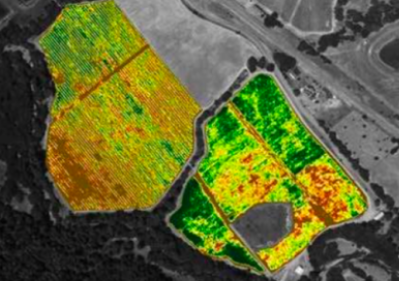

https://www.youtube.com/watch?v=1wyy_qZYgxQ&t=4490s


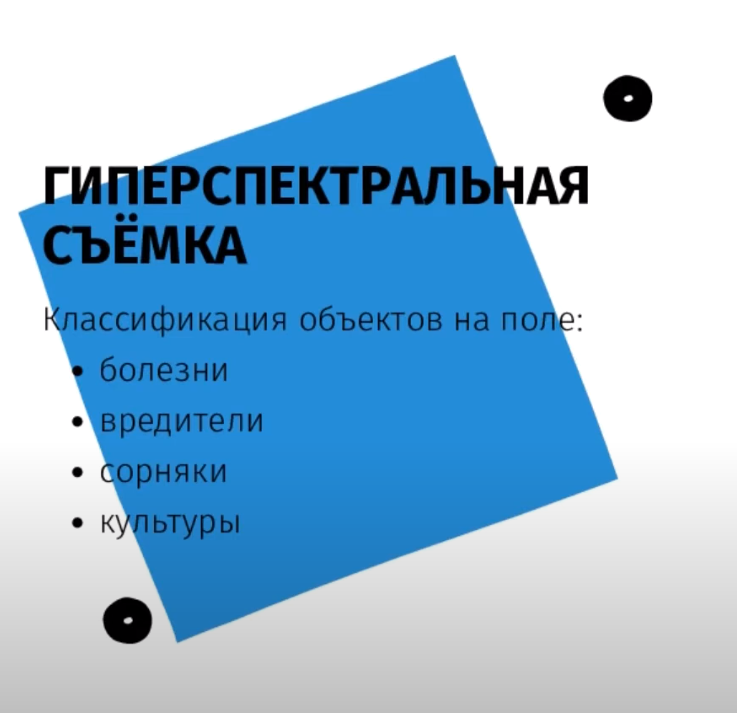


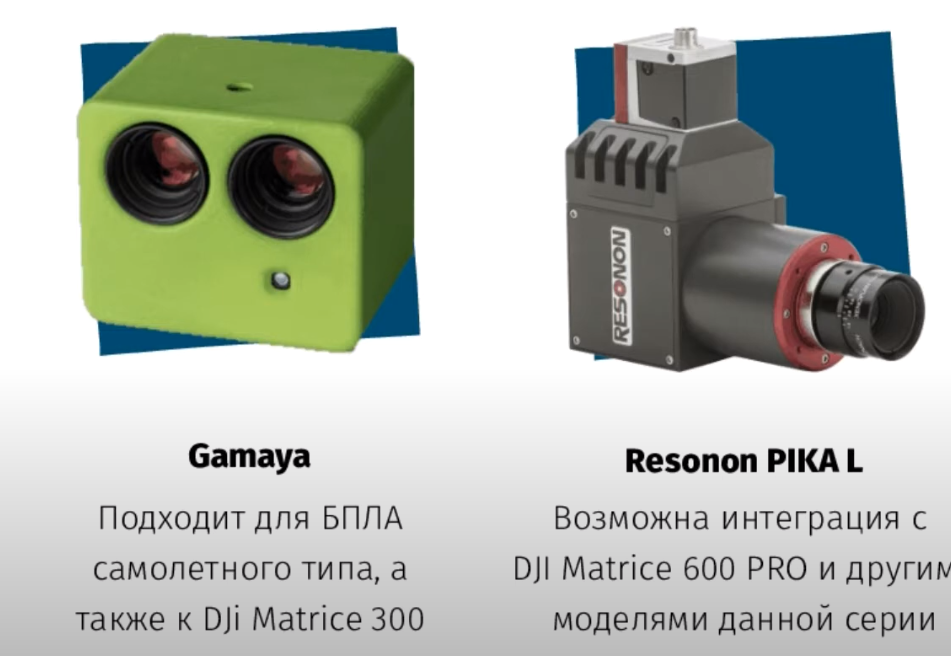



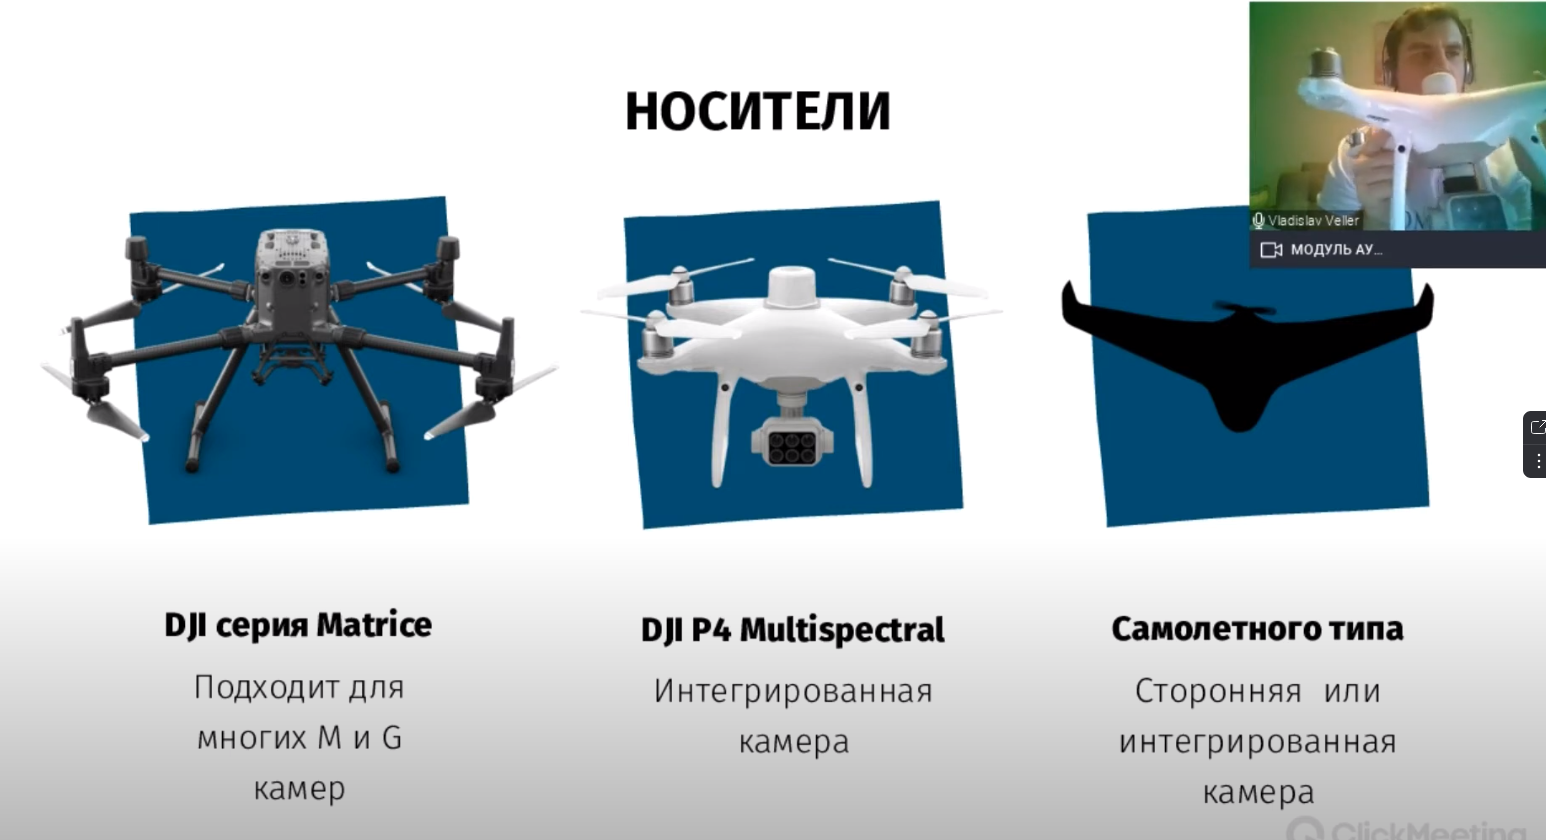
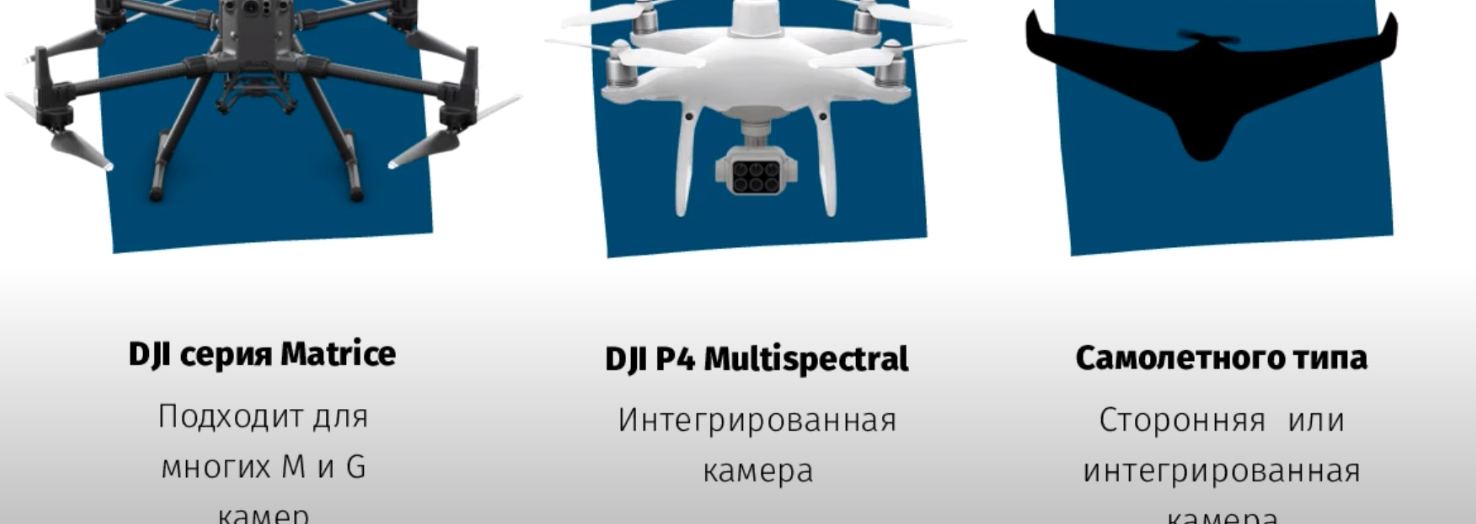

Если дроны исопльзовать нельзя, можно с роверов пытатьс

Полуим географические координаты Шато де Талю в г. Геленджик

In [64]:

#
geolocator = Nominatim(user_agent="Maps")
place_3 = "Геленджик, Шато де Талю" #перекресток Красная Севрная
geo_loc = geolocator.geocode(place_3)
location_3 = [geo_loc.latitude, geo_loc.longitude]
print(location_3)

[44.54237775, 38.08523974715767]


Текущие показания

In [65]:


data = {
    'place': [1, 2, 3, 4, 5, 6, 7, 8, 9,10],
    'humidity_1': [80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
    'humidity_2': [80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
    'humidity_3': [80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
    'humidity_4': [80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
    'humidity_5': [80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
    'Temperature_1': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
    'Temperature_2': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
    'Temperature_3': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
    'Temperature_4': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
    'Temperature_5': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
    'Fenophase': ['цветение', 'цветение', 'смыкание грозди', 'смыкание грозди', 'ягода с горошину', 'ягода с горошину', 'ягода с горошину', 'ягода с горошину', 'размягчение', 'размягчение'],
    'sugar_percent': [95, 88, 88, 78, 88, 95, 93, 95, 59,88],
    'acid_percent': [95, 84, 59, 99, 85, 88, 94, 88, 68,69],
    'fenols_percent': [95, 25, 95, 95, 95, 95, 8, 88, 79,75],
    'Alkans_percent': [95, 55, 95, 95, 88,95, 95, 95, 95,93],
    'latitude':[44.54237775,44.54237775,44.54237775,44.54237775,44.54237775,44.54717552826552,44.54717552826552,44.54717552826552,44.54717552826552,44.54717552826552],
    'longitude':[38.08573974715767,38.08573974715767,38.08573974715767,38.08573974715767,38.08593974715767,38.0863974715767,38.08723974715767,38.08823974715767,38.0893974715767,38.09523974715767],
    'EVI':[0.88,0.92,0.85,0.82,0.81,0.80,0.80,0.82,0.91,0.89],
    'Previous_stage_success':[0.88,0.72,0.55,0.79,0.88,0.60,0.80,0.72,0.91,0.89]
    
    
}

df = pd.DataFrame(data)
# Add temperature forecast columns
df['temperature_forecast_1'] = 25
df['temperature_forecast_2'] = 23
df['temperature_forecast_3'] = 28
df['temperature_forecast_4'] = 29
df['temperature_forecast_5'] = 27

# Add is_rain columns
df['rain_1'] = 0
df['rain_2'] = 1
df['rain_3'] = 1
df['rain_4'] = 1
df['rain_5'] = 0

# Generate the density values
density_values = np.round(np.linspace(6000, 6300, num=10))

# Add density column to the DataFrame
df['density'] = density_values


# Print the updated DataFrame


display(df)


,place,humidity_1,humidity_2,humidity_3,humidity_4,humidity_5,Temperature_1,Temperature_2,Temperature_3,Temperature_4,...,temperature_forecast_2,temperature_forecast_3,temperature_forecast_4,temperature_forecast_5,rain_1,rain_2,rain_3,rain_4,rain_5,density
0,1,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6000.0
1,2,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6033.0
2,3,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6067.0
3,4,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6100.0
4,5,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6133.0
5,6,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6167.0
6,7,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6200.0
7,8,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6233.0
8,9,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6267.0
9,10,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6300.0


Подсветим значения где требуемые показатели выходят за границу. Пусть это будут фенолы

In [66]:
np.random.seed(42)

# Add a new column "output" with random values from 20 to 80
df['output'] = np.random.randint(20, 81, size=len(df))

In [67]:

# Assuming you already have the DataFrame 'df' containing the data

# Define a function to highlight cells based on the condition
def highlight_cells(value):
    if value > 90:  # Specify the condition for highlighting
        return 'background-color: red'
    else:
        return ''

# Apply the function to the "fenols_percent" column
highlighted_df = df.style.applymap(highlight_cells, subset=['fenols_percent'])

# Display the highlighted DataFrame
highlighted_df


,place,humidity_1,humidity_2,humidity_3,humidity_4,humidity_5,Temperature_1,Temperature_2,Temperature_3,Temperature_4,Temperature_5,Fenophase,sugar_percent,acid_percent,fenols_percent,Alkans_percent,latitude,longitude,EVI,Previous_stage_success,temperature_forecast_1,temperature_forecast_2,temperature_forecast_3,temperature_forecast_4,temperature_forecast_5,rain_1,rain_2,rain_3,rain_4,rain_5,density,output
0,1,80,80,80,80,80,25,25,25,25,25,цветение,95,95,95,95,44.542378,38.085740,0.880000,0.880000,25,23,28,29,27,0,1,1,1,0,6000.000000,58
1,2,80,80,80,80,80,25,25,25,25,25,цветение,88,84,25,55,44.542378,38.085740,0.920000,0.720000,25,23,28,29,27,0,1,1,1,0,6033.000000,71
2,3,80,80,80,80,80,25,25,25,25,25,смыкание грозди,88,59,95,95,44.542378,38.085740,0.850000,0.550000,25,23,28,29,27,0,1,1,1,0,6067.000000,48
3,4,80,80,80,80,80,25,25,25,25,25,смыкание грозди,78,99,95,95,44.542378,38.085740,0.820000,0.790000,25,23,28,29,27,0,1,1,1,0,6100.000000,34
4,5,80,80,80,80,80,25,25,25,25,25,ягода с горошину,88,85,95,88,44.542378,38.085940,0.810000,0.880000,25,23,28,29,27,0,1,1,1,0,6133.000000,62
5,6,80,80,80,80,80,25,25,25,25,25,ягода с горошину,95,88,95,95,44.547176,38.086397,0.800000,0.600000,25,23,28,29,27,0,1,1,1,0,6167.000000,27
6,7,80,80,80,80,80,25,25,25,25,25,ягода с горошину,93,94,8,95,44.547176,38.087240,0.800000,0.800000,25,23,28,29,27,0,1,1,1,0,6200.000000,80
7,8,80,80,80,80,80,25,25,25,25,25,ягода с горошину,95,88,88,95,44.547176,38.088240,0.820000,0.720000,25,23,28,29,27,0,1,1,1,0,6233.000000,40
8,9,80,80,80,80,80,25,25,25,25,25,размягчение,59,68,79,95,44.547176,38.089397,0.910000,0.910000,25,23,28,29,27,0,1,1,1,0,6267.000000,58
9,10,80,80,80,80,80,25,25,25,25,25,размягчение,88,69,75,93,44.547176,38.095240,0.890000,0.890000,25,23,28,29,27,0,1,1,1,0,6300.000000,77


In [68]:


def check_fenols_percent(df):
    # Filter the dataframe based on the condition
    filtered_df = df[df['fenols_percent'] < 80]
    
    if filtered_df.empty:
        print("All lines have fenols_percent greater than or equal to 80 percent.")
    else:
        print("Клетки с низким уровнем фенола")
        for index, row in filtered_df.iterrows():
            print(f"Клетка {index + 1}")
        print()

# Assuming you already have the DataFrame 'df' containing the data

# Call the function to check the fenols_percent values
check_fenols_percent(df)


Клетки с низким уровнем фенола
Клетка 2
Клетка 7
Клетка 9
Клетка 10



### Исторические данные
Добавим исторические данные по наблюдениям с колонкой output - итоговым урожаем при текущих условиях


In [69]:
np.random.seed(42)

# Add a new column "output" with random values from 20 to 80
df['output'] = np.random.randint(20, 81, size=len(df))


np.random.seed(42)

# Create a bootstrap sample with 1000 lines
df_outcomes = df.sample(n=1000, replace=True)

# Print the bootstrap sample
display(df_outcomes)


,place,humidity_1,humidity_2,humidity_3,humidity_4,humidity_5,Temperature_1,Temperature_2,Temperature_3,Temperature_4,...,temperature_forecast_3,temperature_forecast_4,temperature_forecast_5,rain_1,rain_2,rain_3,rain_4,rain_5,density,output
6,7,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6200.0,80
3,4,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6100.0,34
7,8,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6233.0,40
4,5,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6133.0,62
6,7,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6200.0,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,10,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6300.0,77
9,10,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6300.0,77
7,8,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6233.0,40
1,2,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6033.0,71


In [34]:


# Print the DataFrame with the new column
display(df)

,place,1st_humidity,2nd_humidity,3rd_humidity,4th_humidity,5th_humidity,Temperature_1,Temperature_2,Temperature_3,Temperature_4,...,temperature_forecast-3 day,temperature_forecast-4 day,temperature_forecast-5 day,is_rain_1 day,is_rain_2 day,is_rain_3 day,is_rain_4 day,is_rain_5 day,density,output
0,1,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6000.0,58
1,2,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6033.0,71
2,3,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6067.0,48
3,4,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6100.0,34
4,5,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6133.0,62
5,6,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6167.0,27
6,7,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6200.0,80
7,8,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6233.0,40
8,9,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6267.0,58
9,10,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6300.0,77


Добавм функцию которая подсвтеит участки которые при текущих условиях даст стркои где выход продукта будет ниже требуемого

Выведем строки с выходом урожая меньше 30 тонн с клетки (1 клетка = 4 Га)

In [35]:
df.loc[lambda x:x['output'] <30]

,place,1st_humidity,2nd_humidity,3rd_humidity,4th_humidity,5th_humidity,Temperature_1,Temperature_2,Temperature_3,Temperature_4,...,temperature_forecast-3 day,temperature_forecast-4 day,temperature_forecast-5 day,is_rain_1 day,is_rain_2 day,is_rain_3 day,is_rain_4 day,is_rain_5 day,density,output
5,6,80,80,80,80,80,25,25,25,25,...,28,29,27,0,1,1,1,0,6167.0,27


In [36]:
df['Fenophase'] = df['Fenophase'].astype('category')

### Машинное обучение

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   place                       10 non-null     int64   
 1   1st_humidity                10 non-null     int64   
 2   2nd_humidity                10 non-null     int64   
 3   3rd_humidity                10 non-null     int64   
 4   4th_humidity                10 non-null     int64   
 5   5th_humidity                10 non-null     int64   
 6   Temperature_1               10 non-null     int64   
 7   Temperature_2               10 non-null     int64   
 8   Temperature_3               10 non-null     int64   
 9   Temperature_4               10 non-null     int64   
 10  Temperature_5               10 non-null     int64   
 11  Fenophase                   10 non-null     category
 12  sugar_percent               10 non-null     int64   
 13  acid_percent           

Загрузим датасет со всей историей, и выходом урожая в зависимотсти от параметров


Свернем датасет для более простого обучения, добавив колонку в вегетативным индексом (средним за время наблюдения) и заложим в модель показания успешности прошлого периода фенофазы

In [50]:
training_df = pd.read_excel('vineday_3.xlsx')
training_df
training_df.columns = training_df.columns.str.lower()
training_df['fenophase'] = training_df['fenophase'].astype('category')

`output` -прогнозируемое количество урожая в тоннах

Проанализируем  зависимость Evi и Output

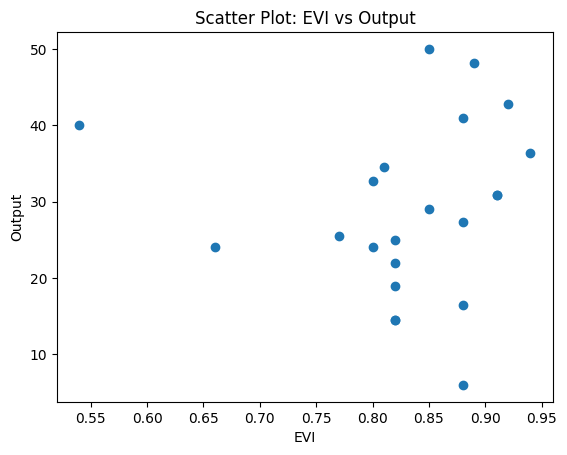

In [51]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(training_df['evi'], training_df['output'])

# Set labels for the x-axis and y-axis
plt.xlabel('EVI')
plt.ylabel('Output')

# Set a title for the plot
plt.title('Scatter Plot: EVI vs Output')

# Display the plot
plt.show()


In [52]:

bootstrapped_df = training_df.sample(n=1000, replace=True, random_state=42)

# bootstrapped_test_df = test_df.sample(n=1000, replace=True, random_state=42)

In [53]:
bootstrapped_df
multiplier = np.random.uniform(0.95, 1.05, len(bootstrapped_df))

# Multiply the 'output' column by the generated multipliers
bootstrapped_df['output'] = bootstrapped_df['output'] * multiplier
bootstrapped_df['humidity_3'] = np.round(bootstrapped_df['humidity_3'] * multiplier)
bootstrapped_df['evi'] = bootstrapped_df['evi'] * multiplier

<Axes: >

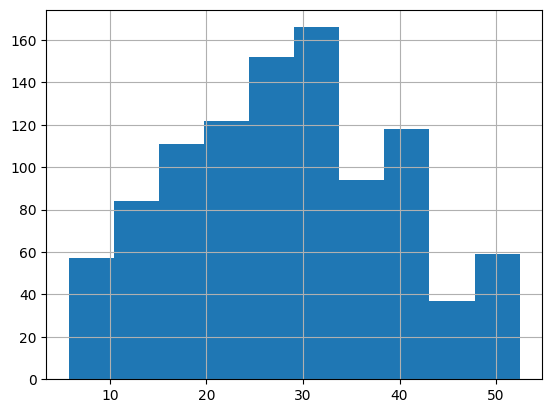

In [54]:
bootstrapped_df['output'].hist()

In [60]:
bootstrapped_df.to_csv('training_data.csv',index = False)

In [63]:
df_ = pd.read_csv(f'training_data.csv')
df_.info()
df_['fenophase'] = df_['fenophase'].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   place                   1000 non-null   int64  
 1   humidity_1              1000 non-null   int64  
 2   humidity_2              1000 non-null   int64  
 3   humidity_3              1000 non-null   float64
 4   humidity_4              1000 non-null   int64  
 5   humidity_5              1000 non-null   int64  
 6   temperature_1           1000 non-null   int64  
 7   temperature_2           1000 non-null   int64  
 8   temperature_3           1000 non-null   int64  
 9   temperature_4           1000 non-null   int64  
 10  temperature_5           1000 non-null   int64  
 11  fenophase               1000 non-null   object 
 12  sugar_percent           1000 non-null   int64  
 13  acid_percent            1000 non-null   int64  
 14  fenols_percent          1000 non-null   i

Обучим и сохраним модель

In [64]:
regressor = lgb.LGBMRegressor()
X=df_.drop(columns = 'output')
y = df_['output']
regressor.fit(X, y)


with open('harvest_pred_model', 'wb') as f:
    pickle.dump(regressor, f)


In [49]:


# # Split the data into features (X) and target variable (y)
# X = bootstrapped_df.drop('output', axis=1)
# y = bootstrapped_df['output']

# # # Split the data into train and test sets
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the categorical features
# categorical_features = ['Fenophase']

# # Create the LightGBM regressor
# regressor = lgb.LGBMRegressor()

# # Fit the regressor on the training data
# regressor.fit(X_train, y_train)


# X_test = bootstrapped_test_df.drop("output", axis=1)
# y_test = bootstrapped_test_df["output"]

# # Make predictions on the test data
# y_pred = regressor.predict(X_test)

# # Calculate the root mean squared error (RMSE)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print('RMSE:', rmse)


Модель выдает не черный ящик, а конкретный вклад факторов в предсказания

### Предсказания

In [65]:
data_for_predictions = pd.read_excel('data_for_predictions.xlsx', header=1)
data_for_predictions.columns = data_for_predictions.columns.str.lower()

In [27]:
data_for_predictions

,place,humidity_1,humidity_2,humidity_3,humidity_4,humidity_5,temperature_1,temperature_2,temperature_3,temperature_4,...,temperature_forecast_2,temperature_forecast_3,temperature_forecast_4,temperature_forecast_5,rain_1,rain_2,rain_3,rain_4,rain_5,density
0,1,80,80,80,80,80,25,25,25,25,...,21,28,29,27,0,1,1,1,0,5900
1,2,80,80,80,80,80,25,25,25,25,...,22,28,29,27,0,0,0,1,0,6055
2,3,80,80,80,80,80,25,25,25,25,...,25,28,29,27,0,1,1,1,0,6167
3,4,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6500
4,5,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,0,0,0,0,6233
5,6,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,5900
6,7,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6400
7,8,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6433
8,9,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6444
9,10,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,1,6600


In [66]:
data_for_predictions['fenophase']= data_for_predictions['fenophase'].astype('category')

In [67]:
regressor.predict(data_for_predictions)

array([40.73648875, 42.74218203, 28.9772659 , 40.66312266, 34.76626982,
       24.04919833, 32.40714979, 19.27462735, 26.87623886, 48.15020344])

In [41]:
data_for_predictions

,place,humidity_1,humidity_2,humidity_3,humidity_4,humidity_5,temperature_1,temperature_2,temperature_3,temperature_4,...,temperature_forecast_2,temperature_forecast_3,temperature_forecast_4,temperature_forecast_5,rain_1,rain_2,rain_3,rain_4,rain_5,density
0,1,80,80,80,80,80,25,25,25,25,...,21,28,29,27,0,1,1,1,0,5900
1,2,80,80,80,80,80,25,25,25,25,...,22,28,29,27,0,0,0,1,0,6055
2,3,80,80,80,80,80,25,25,25,25,...,25,28,29,27,0,1,1,1,0,6167
3,4,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6500
4,5,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,0,0,0,0,6233
5,6,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,5900
6,7,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6400
7,8,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6433
8,9,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,0,6444
9,10,80,80,80,80,80,25,25,25,25,...,23,28,29,27,0,1,1,1,1,6600


In [42]:
prediction_dict = data_for_predictions.to_dict(orient="records")

with open('prediction_dict', 'wb') as f:
    pickle.dump(prediction_dict, f)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


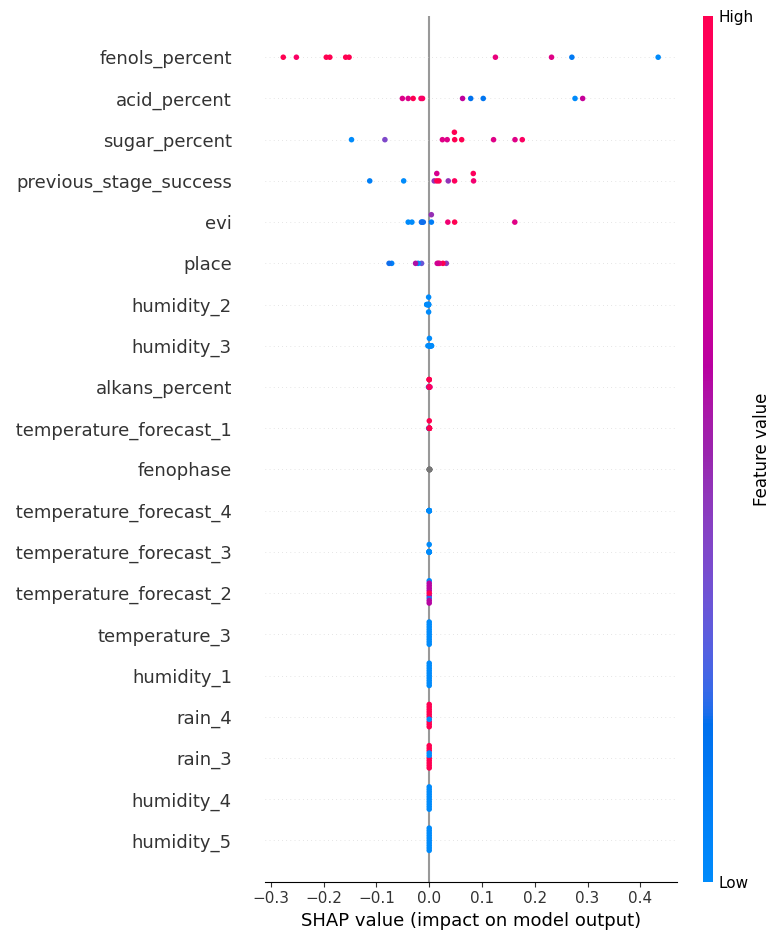

In [43]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(data_for_predictions)

shap.summary_plot(shap_values, data_for_predictions)

In [44]:
n=9
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[n,:], data_for_predictions.iloc[n,:])

In [45]:
n=9
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[8,:], data_for_predictions.iloc[n,:])

In [103]:
for values in dict_.values():
    print(len(values))

TypeError: object of type 'int' has no len()